# **Combined Cycle Power Plant Veri Seti**

Bu veri seti, bir kombine çevrim güç santralinin tam yükte çalıştığı 6 yıllık (2006-2011) verilere dayanmaktadır ve toplam 9568 satırdan oluşmaktadır. Excel formatında sunulan veri setinde **SAYFA2 (Sheet2)** kullanılacaktır. Verilerde ortam sıcaklığı (AT), egzoz vakumu (V), ortam basıncı (AP) ve bağıl nem (RH) gibi özellikler yer almakta olup, santralin **net saatlik elektrik enerjisi çıktısı (PE)** tahmin edilmeye çalışılacaktır. Bu, bir regresyon problemi olarak ele alınabilir.


# **Gerekli Kütüphanelerin Yüklenmesi:**
- **_Pandas:_** Veri işleme ve analiz için
- **_NumPy:_** Sayısal hesaplamalar ve dizi işlemleri için
- **_Matplotlib:_** Veri görselleştirme ve grafik çizimi için
- **_Scikit-learn:_** Makine öğrenmesi algoritmaları ve veri ön işleme araçları için
- * Veri setinin eğitim ve test seti olarak bölünmesinde **train_test_split**,  
- * Verilerin (0,1) aralığında ölçeklendirilmesinde **MinMaxScaler**,  
- * Destek Vektör Regresyonu (SVR) modelinin oluşturulmasında **SVR**,  
- * Modelin hiperparametre optimizasyonunda **GridSearchCV**,  
- * Modelin performansını değerlendirmek için **mean_squared_error** ve **r2_score**,    
- * Confusion Matrix oluşturulmasında ise **confusion_matrix** kütüphaneleri kullanılmıştır.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix


## **Excel verisinin çalışma ortamına aktarılması**

In [2]:
d_adi = 'Folds5x2_pp.xlsx'
data = pd.read_excel(d_adi, sheet_name='Sheet2')
display(data)

,AT,V,AP,RH,PE
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58
...,...,...,...,...,...
9563,17.10,49.69,1005.53,81.82,457.32
9564,24.73,65.34,1015.42,52.80,446.92
9565,30.44,56.24,1005.19,56.24,429.34
9566,23.00,66.05,1020.61,80.29,421.57


# **Özelliklerin dağılımlarını histogramlarla görselleştirme**
## **_Değişkenler_**

1. **AT (Temperature)**: Ortam sıcaklığı (°C)  
2. **V (Exhaust Vacuum)**: Egzoz vakumu (cm Hg)  
3. **AP (Ambient Pressure)**: Ortam basıncı (mbar)  
4. **RH (Relative Humidity)**: Bağıl nem (%)  
5. **PE (Net Hourly Electrical Energy Output)**: Net saatlik elektrik enerjisi çıktısı (MW)  
   *(Tahmin edilecek hedef değişkeni)*

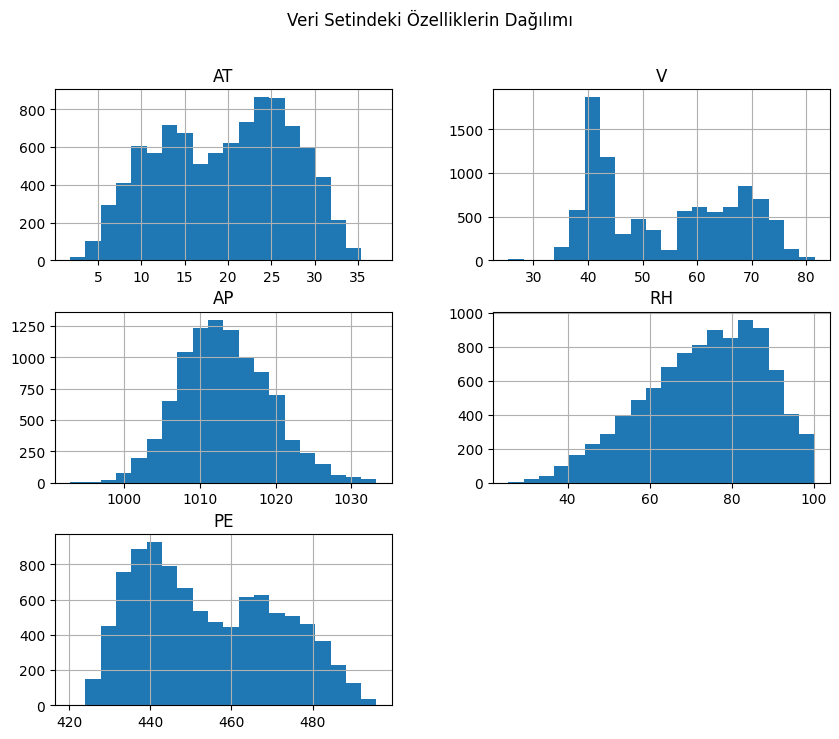

In [3]:
data.hist(figsize=(10, 8), bins=20)
plt.suptitle("Veri Setindeki Özelliklerin Dağılımı")
plt.show()


# Bağımsız ve Bağımlı Değişkenlerin Seçimi

- **Bağımsız Değişkenler (X)**: `'AT'`, `'AP'`, `'RH'`, `'V'`  
  Santralin çalışma koşullarını (ortam sıcaklığı, basınç, bağıl nem ve egzoz vakumu) temsil eder.  
- **Bağımlı Değişken (y)**: `'PE'`  
  Santralin net saatlik elektrik enerjisi çıktısını temsil eder (tahmin edilecek hedef değişken).  

Kod, bağımsız değişkenleri ve hedef değişkeni ayırarak veriyi modellemeye hazır hale getirir.


In [4]:
# Bağımsız değişkenler (X) ve bağımlı değişken (y)
X = data[['AT', 'AP', 'RH', 'V']]
y = data['PE']

print("Bağımsız Değişkenler (X):\n", X.head())
print("Bağımlı Değişken (y):\n", y.head())


Bağımsız Değişkenler (X):
       AT       AP     RH      V
0   9.59  1017.01  60.10  38.56
1  12.04  1019.72  94.67  42.34
2  13.87  1024.42  81.69  45.08
3  13.72  1017.89  79.08  54.30
4  15.14  1023.78  75.00  49.64
Bağımlı Değişken (y):
 0    481.30
1    465.36
2    465.48
3    467.05
4    463.58
Name: PE, dtype: float64


# Veriyi Eğitim ve Test Setlerine Ayırma

- **`train_test_split(X, y, test_size=0.3, random_state=8)`**: 
  - Veriyi **%70 eğitim** ve **%30 test** setlerine ayırır.
  - **`random_state=8`**: Bölme işlemi için sabit bir rastgelelikik sağlar.
- **`X_train.shape` ve `X_test.shape`**: Eğitim ve test setlerinin boyutlarını yazdırır.


In [5]:
# Veriyi eğitim (%70) ve test (%30) setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

print("Eğitim Seti Boyutu:", X_train.shape)
print("Test Seti Boyutu:", X_test.shape)


Eğitim Seti Boyutu: (6697, 4)
Test Seti Boyutu: (2871, 4)


# Bağımsız ve Bağımlı Değişkenlerin Ölçeklenmesi

- **Bağımsız Değişkenler**: **`MinMaxScaler`** ile **X_train** ve **X_test** verileri 0 ile 1 arası ölçeklenir.
- **Bağımlı Değişken**: **`MinMaxScaler`** ile **y_train** ve **y_test** verileri de 0 ile 1 arası ölçeklenir.



In [6]:
# Bağımsız değişkenlerin ölçeklenmesi
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Bağımlı değişkenin ölçeklenmesi
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Ölçeklenmiş verilerin kontrolü
print("X_train (ölçeklenmiş):\n", X_train[:5])
print("y_train (ölçeklenmiş):\n", y_train[:5])


X_train (ölçeklenmiş):
 [[0.32240437 0.57153521 0.55450237 0.32241993]
 [0.74633305 0.43941279 0.37400135 0.76014235]
 [0.07937877 0.8474745  0.7337847  0.1816726 ]
 [0.30313489 0.73650162 0.84333108 0.3316726 ]
 [0.7633017  0.42423488 0.40677048 0.68327402]]
y_train (ölçeklenmiş):
 [0.58370861 0.1413245  0.92317881 0.66291391 0.20238411]


# SVR Modelini Tanımlama ve Eğitme

- **Model Tanımlama**: **SVR** (Support Vector Regression) modeli, **rbf (radial basis function)** kernel tipi ile oluşturulur.
- **Model Eğitimi**: Model, **X_train** ve **y_train** verileriyle eğitilir. **y_train.ravel()** ile bağımlı değişken 1D'ye dönüştürülür.


In [7]:
# SVR modelini tanımlama
model = SVR(kernel='rbf')  # Kernel tipi rbf (radial basis function) olarak seçildi, isteğe göre değiştirilebilir.

# Modeli eğitme
model.fit(X_train, y_train.ravel())  # y_train.ravel() ile 2D veriyi 1D'ye dönüştürüyoruz.


SVR()

# SVR Modeli için Hiperparametre Optimizasyonu

- **y_train ve y_test'in 1D'ye dönüştürülmesi**: **ravel()** ile 2D veriler 1D'ye dönüştürülür.
- **Hiperparametre Aralıkları**: `C`, `epsilon`, ve `gamma` için daraltılmış değer aralıkları belirlenir.
- **GridSearchCV**: SVR modelinin hiperparametrelerini optimize etmek için **GridSearchCV** kullanılır. 
  - **`cv=3`**: 3 katmanlı çapraz doğrulama.
  - **`scoring='r2'`**: Performans ölçütü olarak **R²** kullanılır.
  - **`n_jobs=-1`**: Tüm işlemci çekirdeklerini kullanarak paralel işlem yapılır.
- **Alt Küme Eğitimi**: Eğitim verilerinin küçük bir alt kümesiyle hiperparametre optimizasyonu yapılır.
- **En İyi Parametrelerin ve Modelin Güncellenmesi**: **`grid_search.best_params_`** ile en iyi parametreler yazdırılır ve model güncellenir.


In [8]:
# y_train ve y_test'in 1D formata dönüştürülmesi
y_train = y_train.ravel()
y_test = y_test.ravel()

# Hiperparametre aralıklarının daraltılması
param_grid = {
    'C': [1, 10],  # Daha dar C aralığı
    'epsilon': [0.01, 0.1],  # Daha dar epsilon aralığı
    'gamma': ['scale', 0.1]  # Daha dar gamma aralığı
}

# GridSearchCV ile SVR hiperparametre optimizasyonu
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3, scoring='r2', n_jobs=-1)

# Eğitim verilerinin küçük bir alt kümesini kullanarak test
X_train_subset = X_train[:int(0.1 * len(X_train))]
y_train_subset = y_train[:int(0.1 * len(y_train))]

grid_search.fit(X_train_subset, y_train_subset)

# En iyi hiperparametreler ve modelin güncellenmesi
print("En İyi Parametreler:", grid_search.best_params_)
model = grid_search.best_estimator_


En İyi Parametreler: {'C': 1, 'epsilon': 0.01, 'gamma': 'scale'}


# En İyi Parametrelerle SVR Modeli ve Tahmin Yapma

- **Model Tanımlama**: En iyi hiperparametrelerle **SVR** (kernel='rbf', C=1, epsilon=0.01, gamma='scale') modeli oluşturulur.
- **Model Eğitimi**: Model, **X_train** ve **y_train** verileriyle eğitilir.
- **Tahmin Yapma**: 
  - **`model.predict(X_train)`** ile eğitim verileri üzerinde tahmin yapılır ve sonuç **y_pred_train**'e atanır.
  - **`model.predict(X_test)`** ile test verileri üzerinde tahmin yapılır ve sonuç **y_pred_test**'e atanır.


In [9]:
# En iyi parametrelerle SVR modelini oluşturma
model = SVR(kernel='rbf', C=1, epsilon=0.01, gamma='scale')

# Modeli eğitme
model.fit(X_train, y_train)

# Tahminlerin yapılması
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


# Ölçeklenmiş Tahminlerin Orijinal Değerlere Dönüştürülmesi

- **`scaler_y.inverse_transform`**: Modelin tahminleri ve gerçek değerler, ölçeklendirme işleminden önceki orijinal değerlere geri dönüştürülür.
  - **`y_pred_train.reshape(-1, 1)`**: **y_pred_train** 1D'den 2D'ye dönüştürülür, çünkü `inverse_transform` fonksiyonu 2D veri bekler.
  - Aynı işlem **`y_pred_test`, `y_train`, ve `y_test`** için de yapılır.
  
Bu işlem, ölçeklendirilmiş (0-1 arası) tahmin ve gerçek değerleri, orijinal değer aralıklarına geri getirir.


In [10]:
y_pred_train_original = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))


# Performans Değerlendirme: Eğitim ve Test Seti

- **Eğitim Seti Performansı**:
  - **`mean_squared_error(y_train, y_pred_train)`**: Eğitim setindeki tahmin hatalarının karelerinin ortalamasını hesaplar.
  - **`r2_score(y_train, y_pred_train)`**: Eğitim setindeki tahminlerin doğruluğunu, **R²** (determinasyon katsayısı) ile ölçer.

- **Test Seti Performansı**:
  - **`mean_squared_error(y_test, y_pred_test)`**: Test setindeki tahmin hatalarını hesaplar.
  - **`r2_score(y_test, y_pred_test)`**: Test setindeki tahmin doğruluğunu ölçer.

- **Sonuçların Yazdırılması**: Eğitim ve test setlerinin **MSE** ve **R²** skorları yazdırılır. 
  - **MSE**: Tahmin hatalarının ortalama kare değeri, düşük olması istenir.
  - **R²**: Modelin ne kadar iyi tahmin yaptığını gösterir, 1'e yakın olmalıdır.


In [11]:
# Performans değerlendirme: Eğitim seti
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Performans değerlendirme: Test seti
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Sonuçları yazdırma
print("Eğitim Seti Performansı:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"R² Score: {r2_train:.4f}")

print("\nTest Seti Performansı:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"R² Score: {r2_test:.4f}")


Eğitim Seti Performansı:
Mean Squared Error (MSE): 0.0027
R² Score: 0.9465

Test Seti Performansı:
Mean Squared Error (MSE): 0.0028
R² Score: 0.9445


# Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması

- **Dağılma Grafiği (scatter plot)**: Gerçek değerler (**mavi**) ve tahmin edilen değerler (**kırmızı**) karşılaştırılır.
Bu grafik, modelin doğruluğunu görsel olarak gösterir.


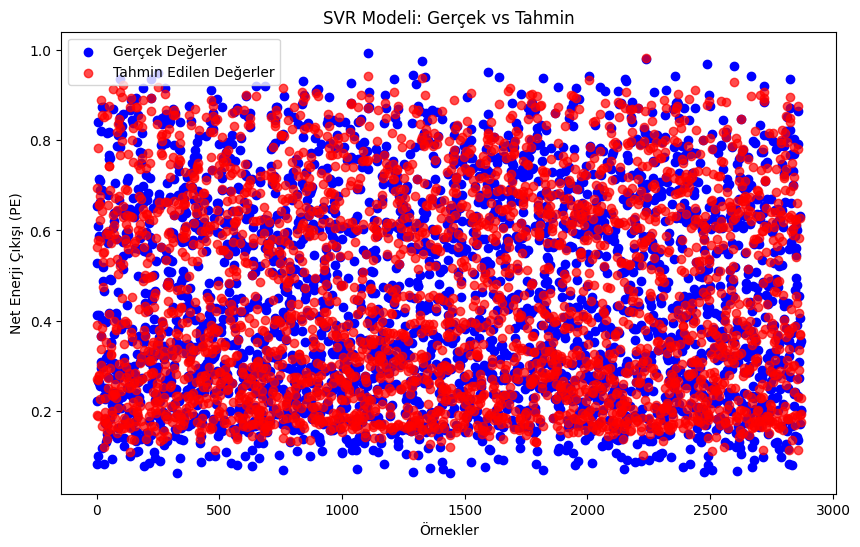

In [12]:
# Tahmin edilen ve gerçek değerlerin karşılaştırılması
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Gerçek Değerler')
plt.scatter(range(len(y_test)), y_pred_test, color='red', label='Tahmin Edilen Değerler', alpha=0.7)
plt.title('SVR Modeli: Gerçek vs Tahmin')
plt.xlabel('Örnekler')
plt.ylabel('Net Enerji Çıkışı (PE)')
plt.legend()
plt.show()

# Eğitim ve Test Seti İçin Tahmin ve Gerçek Değerlerin Karşılaştırılması

- **Eğitim Seti Grafiği**: Gerçek ve tahmin edilen değerler **mavi** noktalarla gösterilir, doğruyu temsil eden kırmızı kesik çizgi eklenir.
- **Test Seti Grafiği**: Test seti için aynı karşılaştırma yapılır, **yeşil** noktalarla gösterilir ve doğruyu temsil eden kırmızı kesik çizgi eklenir.
- **`plt.tight_layout`**: Alt grafiklerin düzenini iyileştirir.
- **`plt.show`**: Grafikleri görüntüler.

Bu grafikler, eğitim ve test setlerinin tahmin ve gerçek değerlerinin karşılaştırmasını sağlar.


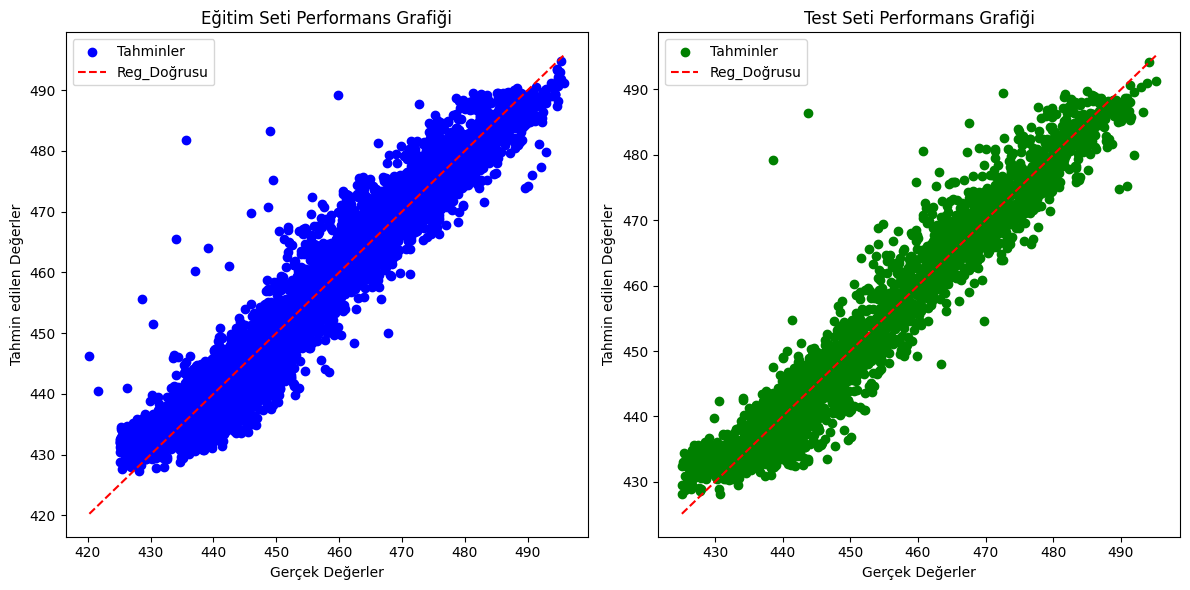

In [13]:
# Eğitim ve test seti için tahmin ve gerçek değerlerin karşılaştırılması
plt.figure(figsize=(12, 6))

# Eğitim Seti Grafiği
plt.subplot(1, 2, 1)
plt.scatter(y_train_original, y_pred_train_original, color='blue', label='Tahminler')
plt.plot([y_train_original.min(), y_train_original.max()], 
         [y_train_original.min(), y_train_original.max()], 'r--', label='Reg_Doğrusu')
plt.title('Eğitim Seti Performans Grafiği')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin edilen Değerler')
plt.legend()

# Test Seti Grafiği
plt.subplot(1, 2, 2)
plt.scatter(y_test_original, y_pred_test_original, color='green', label='Tahminler')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', label='Reg_Doğrusu')
plt.title('Test Seti Performans Grafiği')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin edilen Değerler')
plt.legend()

plt.tight_layout()
plt.show()
